In [22]:
import pickle
from ramannoodles import spectrafit

In [23]:
# open spectra library
shoyu_data_dict = pickle.load(open('../raman_spectra/shoyu_data_dict.p', 'rb'))
# list keys
sorted(shoyu_data_dict.keys())

['2-PROPANOL',
 'CARBON DIOXIDE',
 'CARBON MONOXIDE',
 'DIMETHYL KETONE',
 'ETHYL ALCOHOL',
 'FORMALDEHYDE',
 'FORMIC ACID',
 'WATER']

In [48]:
# extract spectra data
data = shoyu_data_dict['CARBON DIOXIDE']
x_data = data['x']
y_data = data['y']

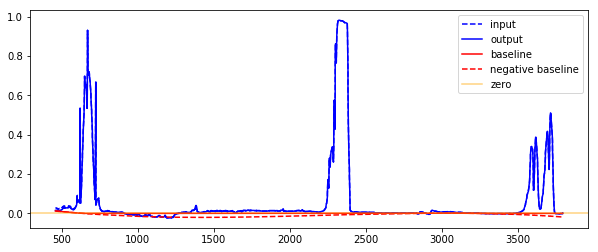

In [49]:
# subtract baseline
y_data = spectrafit.subtract_baseline(y_data, deg=3, plot=True, x_data=x_data)

In [26]:
# detect peaks
peaks = spectrafit.find_peaks(x_data, y_data)

In [27]:
# assign parameters for least squares fit
mod, pars = spectrafit.lorentz_params(peaks)

In [28]:
# fit the model to the data
out = spectrafit.model_fit(x_data, y_data, mod, pars, report=True)

[[Model]]
    ((((((((((((((((((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_')) + Model(lorentzian, prefix='p8_')) + Model(lorentzian, prefix='p9_')) + Model(lorentzian, prefix='p10_')) + Model(lorentzian, prefix='p11_')) + Model(lorentzian, prefix='p12_')) + Model(lorentzian, prefix='p13_')) + Model(lorentzian, prefix='p14_')) + Model(lorentzian, prefix='p15_')) + Model(lorentzian, prefix='p16_')) + Model(lorentzian, prefix='p17_')) + Model(lorentzian, prefix='p18_')) + Model(lorentzian, prefix='p19_')) + Model(lorentzian, prefix='p20_')) + Model(lorentzian, prefix='p21_')) + Model(lorentzian, prefix='p22_')) + Model(lorentzian, prefix='p23_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 186034
    # data points      = 2461
    # variables        = 92
    ch

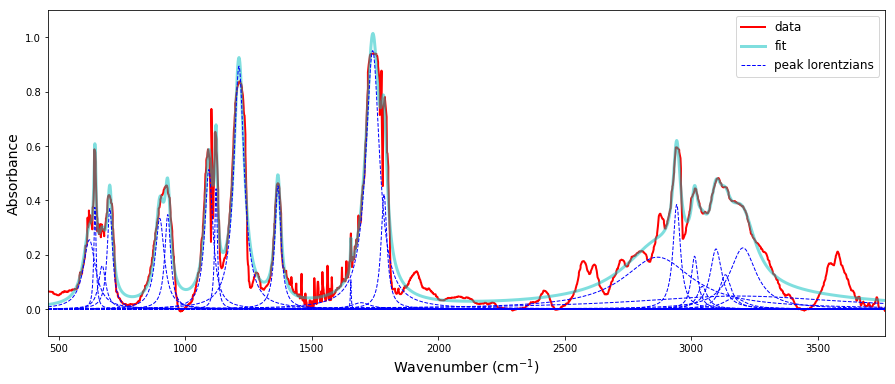

In [29]:
# plot fit results
spectrafit.plot_fit(x_data, y_data, out, plot_components=True)

In [30]:
# export data in logical structure (see docstring)
fit_peak_data = spectrafit.export_fit_data(out)
fit_peak_data

[array([ 29.55416811, 620.29656282,  23.64868851,  59.10833621,
        620.29656282]),
 array([  5.30446092, 642.417986  ,   6.28781472,  10.60892183,
        642.417986  ]),
 array([ 17.27046761, 670.86340915,   8.65266143,  34.54093521,
        670.86340915]),
 array([ 12.70800307, 701.40379201,  14.79990704,  25.41600615,
        701.40379201]),
 array([ 21.79515875, 898.56382719,  22.84129343,  43.5903175 ,
        898.56382719]),
 array([ 13.94689891, 930.21970199,  15.25558625,  27.89379782,
        930.21970199]),
 array([  19.09188104, 1092.6942451 ,   30.77129512,   38.18376209,
        1092.6942451 ]),
 array([   6.30319674, 1121.05159516,    8.76243917,   12.60639348,
        1121.05159516]),
 array([  24.44544082, 1211.77110219,   68.63153073,   48.89088163,
        1211.77110219]),
 array([  14.35495302, 1365.79476192,   20.473454  ,   28.70990604,
        1365.79476192]),
 array([1.80499941e+00, 1.65389811e+03, 6.34713764e-01, 3.60999881e+00,
        1.65389811e+03]),
 a

In [31]:
# print docstring which outlines data structure
spectrafit.export_fit_data.__doc__

'\n    fit_peak_data[i][0] = p[i]_simga\n    fit_peak_data[i][1] = p[i]_center\n    fit_peak_data[i][2] = p[i]_amplitude\n    fit_peak_data[i][3] = p[i]_fwhm\n    fit_peak_data[i][4] = p[i]_center\n    '